# A basic model to try and price the value of an asset

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import root
import matplotlib.pyplot as plt

Starting Parameters

In [2]:
R = 0.055
b = 1/(1+R)
maturity_g = 0.073
time_frame = 10
start_earnings = 10
start_growth = 0.21
k_vec_m = 1 + maturity_g
starting_multiple = 41.9
maturity_multiple = (k_vec_m*b*(1-(k_vec_m*b)**18)/(1-b*k_vec_m))
maturity_multiple

21.219886495538475

In [3]:
# initial low growth for 5 periods
initial_growth = np.linspace(0.06, 0.10, 2)

# accelerated growth for 10 periods
accelerated_growth = np.linspace(0.10, 0.20, 5)

decelerated_growth = np.linspace(0.20, 0.10, 5)

# decelerated growth for 5 periods
sustained_growth = np.linspace(0.10, 0.05, 5)

# stable mature growth for 5 periods
mature_growth = np.linspace(0.05, 0.03, 8)

# concatenate all growth periods to form the 25 period list
earnings_growth = (np.concatenate((initial_growth, accelerated_growth, decelerated_growth, sustained_growth, mature_growth)))

#plt.plot(range(len(earnings_growth)), earnings_growth)
#plt.show()
#earnings_growth = [0.06,0.10,0.20,0.30,0.35,0.37,0.40,0.31,0.22,0.11, 0.13, 0.09, 0.08, 0.085] 
earnings_growth = [0.21, 0.21, 0.21, 0.18, 0.19, 0.16, 0.10, 0.08, 0.09, 0.075]

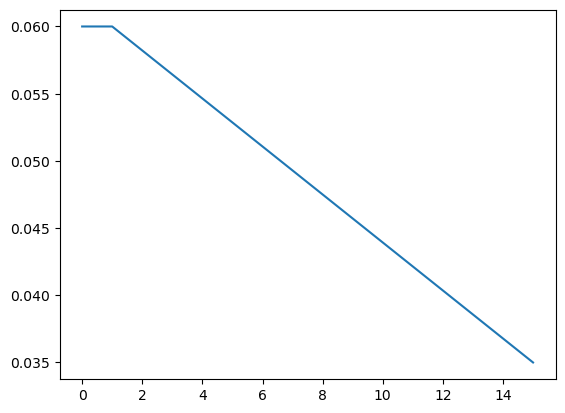

In [4]:
def predict_growth(start_value, extra_growth: float = 0, i: int = 9, time_to_mature: int = 25):
    # Initialize the list with the first two values
    len = time_to_mature-i
    g_vec = [start_value + extra_growth, start_value + extra_growth**2.4]
    
    # Calculate the decrement needed to reach 0.035 in len-2 steps
    decrement = (g_vec[-1] - 0.035) / (len-2)

    # Add the next five values to the list
    for i in range(len-2):
        exponent = ((i+4))
        #print(exponent)
        #print(extra_growth**exponent)
        g_vec.append(g_vec[-1] - decrement + extra_growth**exponent)
    
    return g_vec
plt.plot(range(len(predict_growth(0.06))), predict_growth(0.06))
plt.show()

In [5]:

asset_df = pd.DataFrame({'earnings': start_earnings*np.cumprod([1+g for g in earnings_growth]), 'earnings_growth': earnings_growth, 'expected_earnings_growth': [start_growth] * time_frame})


The multiples assume that growth continues at the current rate for a certain set of years and then trails back down to maturity

In [6]:
def predict_multiple(start_value: float = 0.06, pre_predicted = False, i = 1, adjust: bool = False, investor_time_frame: int = 5):
    
    if adjust:
        extra_growth = asset_df.earnings_growth[i] - asset_df.expected_earnings_growth[i]
    else:
        extra_growth = 0 #((()/ (asset_df.expected_earnings[]))-1)
    growth = [1 + g for g in predict_growth(asset_df.earnings_growth[i], extra_growth=extra_growth, i = i)]
    
    b_vec = [b] * len(growth)
    b_vec = np.cumprod(b_vec)[:investor_time_frame]
    k_vec = np.cumprod(growth)[:investor_time_frame]
    if i < time_frame:
        asset_df.loc[i+1:, 'expected_earnings_growth'] = [g - 1 for g in growth[:time_frame-(i+1)]]
   
    return sum(k_vec*b_vec) + maturity_multiple*b_vec[-1]*k_vec[-1]
predict_multiple(pre_predicted=True, i=9)
#[predict_multiple(pre_predicted=True, i=i) for i in asset_df.index[:]]

28.201901022133175

In [7]:
asset_df['expected_earnings_growth'] = [start_growth] * time_frame
predict_multiple(pre_predicted=True, i=3)
#asset_df['expected_earnings_growth']

42.77329866117028

In [8]:
def gen_multiples(df: pd.DataFrame = asset_df):
    multiples = [starting_multiple]
    multiples.extend(list(np.zeros(len(df.earnings_growth)-1)))
    df['multiples'] = multiples
    df.loc[1:, 'multiples'] = [predict_multiple(pre_predicted=True, i=i) for i in asset_df.index[1:]]
    return None

In [9]:
def gen_mkt_cap(df: pd.DataFrame = asset_df):
    asset_df['mkt_cap'] = asset_df.earnings*asset_df.multiples
    return None

In [10]:
def gen_cum_earnings(df: pd.DataFrame = asset_df):
    df['cum_earnings'] = df['earnings'].cumsum().shift(1)
    df.loc[0,'cum_earnings'] = 0
    return None


In [11]:
def gen_roi(df: pd.DataFrame = asset_df):
    roi = [0]
    roi.extend(list(np.zeros(len(df.earnings_growth)-1)))
    df['roi'] = roi
    df.loc[1:,'roi'] = ((df.loc[1:,'mkt_cap'] + df.loc[1:,'cum_earnings'])/df['mkt_cap'][0])**(1/df.index[1:]) - 1

    return None

In [12]:
def gen_props_of_return(df: pd.DataFrame = asset_df):
    df['appreciation_prop'] = (df['mkt_cap'] - df['mkt_cap'][0])/(df['mkt_cap']  - df['mkt_cap'][0] + df['cum_earnings'])
    df['earnings_prop'] = df['cum_earnings']/(df['mkt_cap']  - df['mkt_cap'][0] + df['cum_earnings'])
    df.loc[0,'appreciation_prop'] = 0
    df.loc[0,'earnings_prop'] = 0
    return None

In [13]:
def gen_extra_cols():
    gen_multiples()
    gen_mkt_cap()
    gen_cum_earnings()
    gen_roi()
    gen_props_of_return()
    return None

In [14]:
gen_extra_cols()

In [15]:


asset_df = asset_df.round(2)
asset_df


,earnings,earnings_growth,expected_earnings_growth,multiples,mkt_cap,cum_earnings,roi,appreciation_prop,earnings_prop
0,12.10,0.21,0.21,41.90,506.99,0.00,0.00,0.00,0.00
1,14.64,0.21,0.21,48.04,703.29,12.10,0.41,0.94,0.06
2,17.72,0.21,0.21,47.95,849.51,26.74,0.31,0.93,0.07
3,20.90,0.18,0.21,42.77,894.15,44.46,0.23,0.90,0.10
4,24.88,0.19,0.18,44.33,1102.87,65.36,0.23,0.90,0.10
5,28.86,0.16,0.19,39.50,1139.97,90.24,0.19,0.88,0.12
6,31.74,0.10,0.16,31.24,991.69,119.09,0.14,0.80,0.20
7,34.28,0.08,0.10,28.82,988.10,150.84,0.12,0.76,0.24
8,37.37,0.09,0.08,29.96,1119.57,185.12,0.13,0.77,0.23
9,40.17,0.08,0.09,28.20,1132.85,222.48,0.12,0.74,0.26


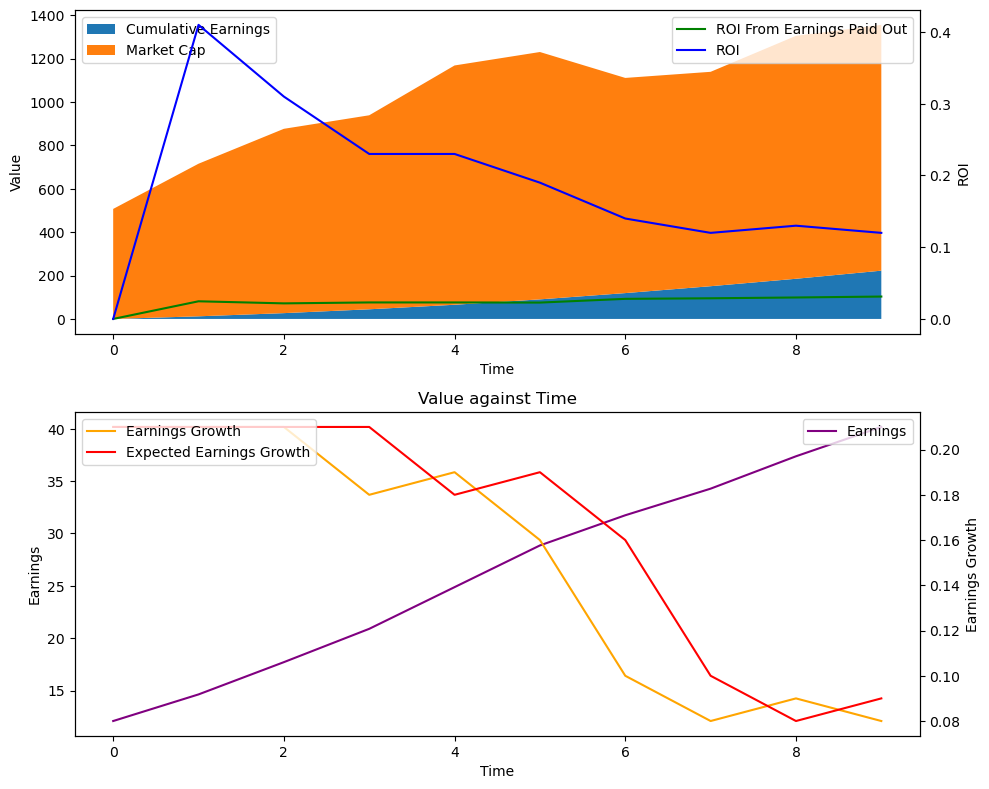

<Figure size 640x480 with 0 Axes>

In [16]:
import numpy as np
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(10, 8))  # Create a new figure and two subplots

# First subplot for Market Cap and Cumulative Earnings
# Use fill_between function instead of bar to create stacked area chart
ax1.fill_between(asset_df.index, asset_df.cum_earnings, label='Cumulative Earnings')
ax1.fill_between(asset_df.index, asset_df.cum_earnings + asset_df.mkt_cap, asset_df.cum_earnings, label='Market Cap')

ax1.set_xlabel('Time')  # Add an x-label to the axes.
ax1.set_ylabel('Value')  # Add a y-label to the axes.
ax1.legend(loc='upper left')  # Add a legend.

# Create a secondary axis for the first subplot
ax1b = ax1.twinx()
ax1b.plot(asset_df.index, asset_df.earnings_prop * asset_df.roi, label='ROI From Earnings Paid Out', color='green')
ax1b.plot(asset_df.index, asset_df.roi, label='ROI', color='blue')
ax1b.set_ylabel('ROI')  # Add a y-label to the axes.
ax1b.legend(loc='upper right')  # Add a legend.
#plt.savefig("plot1.svg", format='svg')


# Second subplot for Earnings
ax3.plot(asset_df.index, asset_df.earnings, label='Earnings', color='purple')  # Plot the 'earnings' series on the second y-axis
ax3.set_xlabel('Time')  # Add an x-label to the axes.
ax3.set_ylabel('Earnings')  # Add a y-label to the axes.
ax3.legend(loc='upper right')  # Add a legend.

# Create a secondary axis for the second subplot
ax3b = ax3.twinx()
ax3b.plot(asset_df.index, asset_df.earnings_growth, label='Earnings Growth', color='orange')
ax3b.plot(asset_df.index, asset_df.expected_earnings_growth, label='Expected Earnings Growth', color='red')  # Plot the 'earnings_growth' series on the second y-axis
ax3b.set_ylabel('Earnings Growth')  # Add a y-label to the axes.
ax3b.legend(loc='upper left')  # Add a legend.

plt.title('Value against Time')  # Add a title to the plot
plt.tight_layout()  # Adjust the layout
plt.show()  # Display the plot
plt.savefig("plot2.svg", format='svg')

